In [ ]:
!pip install keras-tuner  # Install the missing module

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install scikeras

Epoch 1/10


<ipython-input-4-a98afe170270>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0691 - val_loss: 0.0165
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0249 - val_loss: 0.0161
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0235 - val_loss: 0.0157
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0222 - val_loss: 0.0155
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0247 - val_loss: 0.0152
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0220 - val_loss: 0.0160
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0223 - val_loss: 0.0154
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0201 - val_loss: 0.0170
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0230 - val_loss: 0.0164
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0207 - val_loss: 0.0164


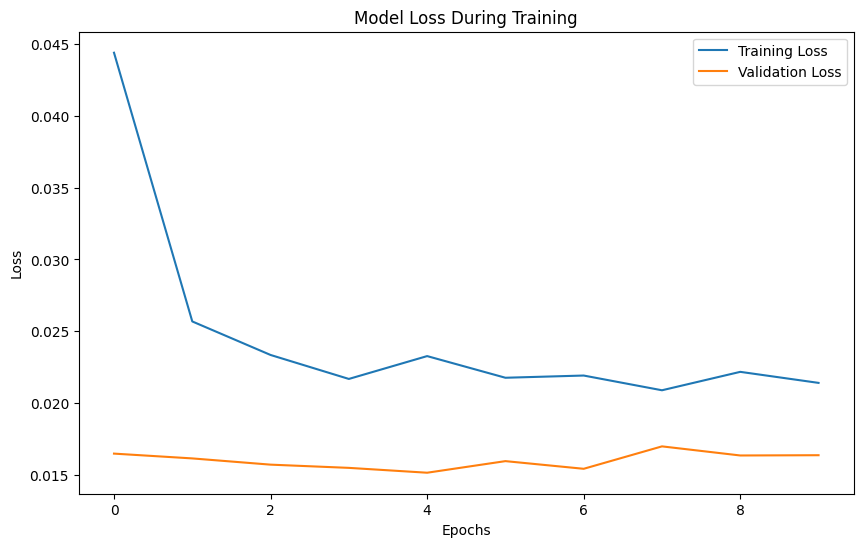

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


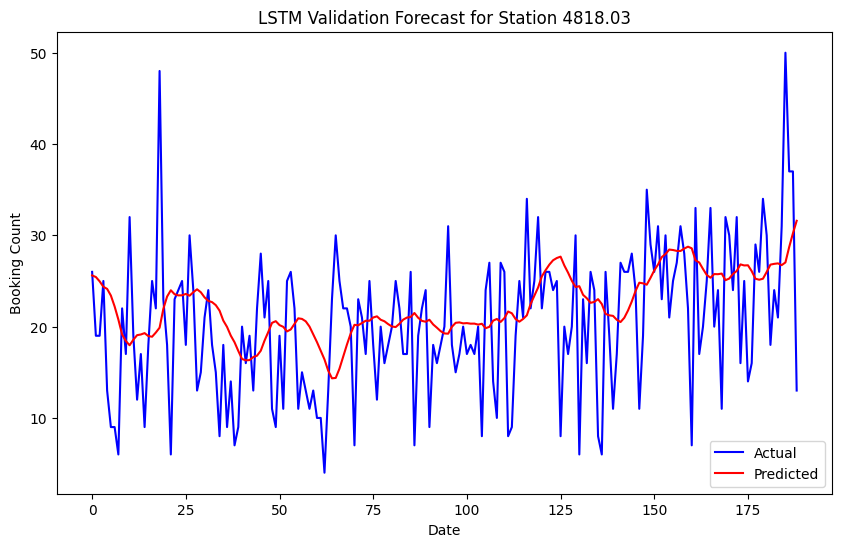

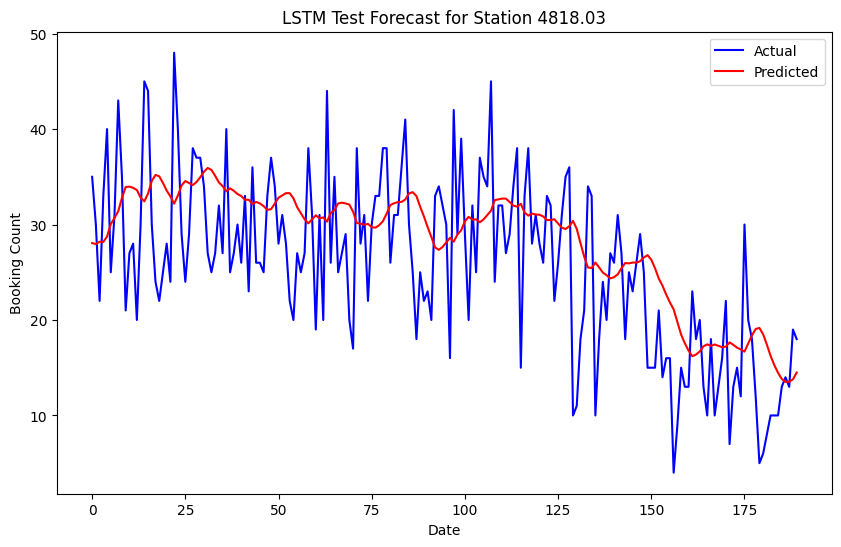

Validation Set Evaluation Metrics:
MSE: 62.928439895682985
MAE: 6.128602330646817
RMSE: 7.9327447895216565
MAPE: 46.24348030257235%

Test Set Evaluation Metrics:
MSE: 56.06103660087708
MAE: 6.161464540581954
RMSE: 7.487391842349182
MAPE: 33.345063141583346%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the datasets
file_paths = [
    "/content/2021Citibike daily trip counts&weather.csv",
    "/content/2022Citibike daily trip counts&weather.csv",
    "/content/2023Citibike daily trip counts&weather.csv",
    "/content/2024Citibike daily trip counts&weather.csv",
    "/content/Final_Urban_Feaatures_Merged_csv.csv"
]

# Load each CSV file
df_2021 = pd.read_csv(file_paths[0], dtype={'start_station_id': str})
df_2022 = pd.read_csv(file_paths[1], dtype={'start_station_id': str})
df_2023 = pd.read_csv(file_paths[2], dtype={'start_station_id': str})
df_2024 = pd.read_csv(file_paths[3], dtype={'start_station_id': str})
df_urban = pd.read_csv(file_paths[4])

# Combine the Citibike trip data for all years
df = pd.concat([
    df_2021[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2022[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2023[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2024[['start_station_id', 'DATE', 'booking_count', 'TAVG']]
])

# Filter the data for station 4818.03 only
df_station = df[df['start_station_id'] == '4818.03']

# Convert 'DATE' to datetime format
df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')

# Use the 'TAVG' as the temperature column directly
df_station = df_station.dropna(subset=['booking_count', 'DATE'])

# Rename columns to match LSTM input format
df_station.rename(columns={'DATE': 'ds', 'booking_count': 'y', 'TAVG': 'temperature'}, inplace=True)

# Sort the data by 'ds' (date)
df_station = df_station.sort_values('ds')

# Split data into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(df_station))
val_size = int(0.15 * len(df_station))

train = df_station[:train_size]
validation = df_station[train_size:train_size + val_size]
test = df_station[train_size + val_size:]

# Normalize the 'y' values (booking_count) and 'temperature'
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_temp = MinMaxScaler(feature_range=(0, 1))

train_scaled_y = scaler_y.fit_transform(train[['y']])
validation_scaled_y = scaler_y.transform(validation[['y']])
test_scaled_y = scaler_y.transform(test[['y']])

train_scaled_temp = scaler_temp.fit_transform(train[['temperature']])
validation_scaled_temp = scaler_temp.transform(validation[['temperature']])
test_scaled_temp = scaler_temp.transform(test[['temperature']])

# Prepare the data for LSTM: Reshape the data into sequences (look-back window)
def create_sequences(data_y, data_temp, window_size):
    X, y = [], []
    for i in range(window_size, len(data_y)):
        X.append(np.column_stack((data_y[i-window_size:i], data_temp[i-window_size:i])))
        y.append(data_y[i])
    return np.array(X), np.array(y)

# Window size for LSTM (number of previous days to use for forecasting)
window_size = 30

X_train, y_train = create_sequences(train_scaled_y, train_scaled_temp, window_size)
X_val, y_val = create_sequences(validation_scaled_y, validation_scaled_temp, window_size)
X_test, y_test = create_sequences(test_scaled_y, test_scaled_temp, window_size)

# Reshape the data for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))  # 2 features: booking_count and temperature
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 2))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer with one value for prediction

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Invert scaling to get actual values
y_pred_val = scaler_y.inverse_transform(y_pred_val)
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot validation results
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(y_pred_val, label='Predicted', color='red')
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Plot test results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red')
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = sqrt(mse_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"Validation Set Evaluation Metrics:")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nTest Set Evaluation Metrics:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")


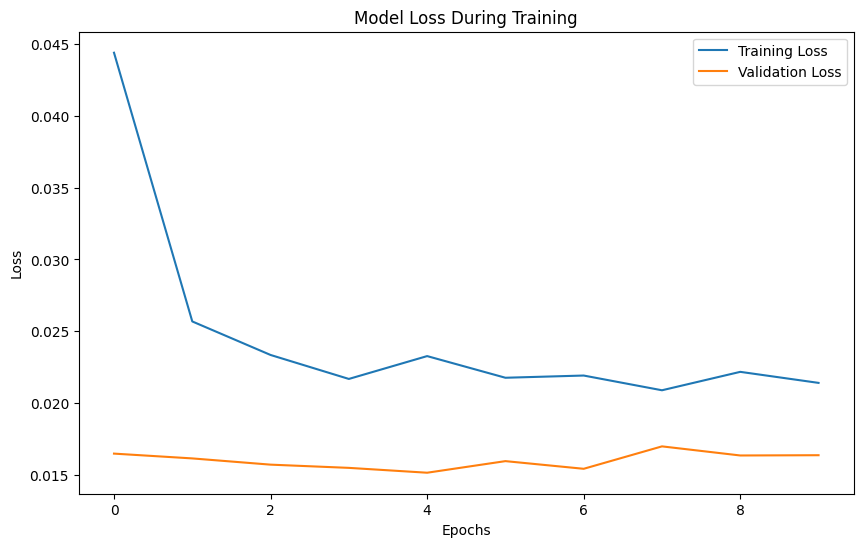

In [ ]:
# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/50


<ipython-input-47-dcb159b626df>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.1874 - val_loss: 0.0120
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0275 - val_loss: 0.0108
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0214 - val_loss: 0.0100
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0197 - val_loss: 0.0098
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0192 - val_loss: 0.0097
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0189 - val_loss: 0.0109
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0198 - val_loss: 0.0097
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0231 - val_loss: 0.0109
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0178 - val_loss: 0.0098
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0191 - val_loss: 0.0105
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0153 - val_loss: 0.0119
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0206 - val_l

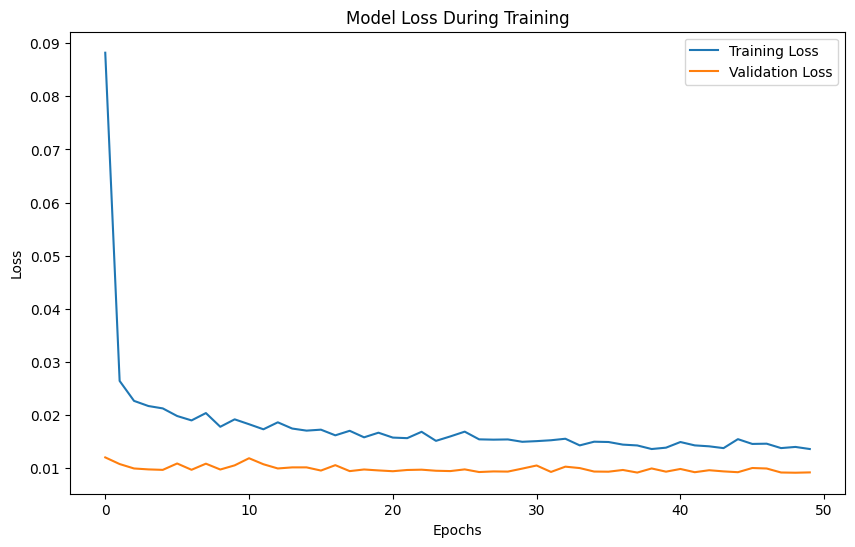

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


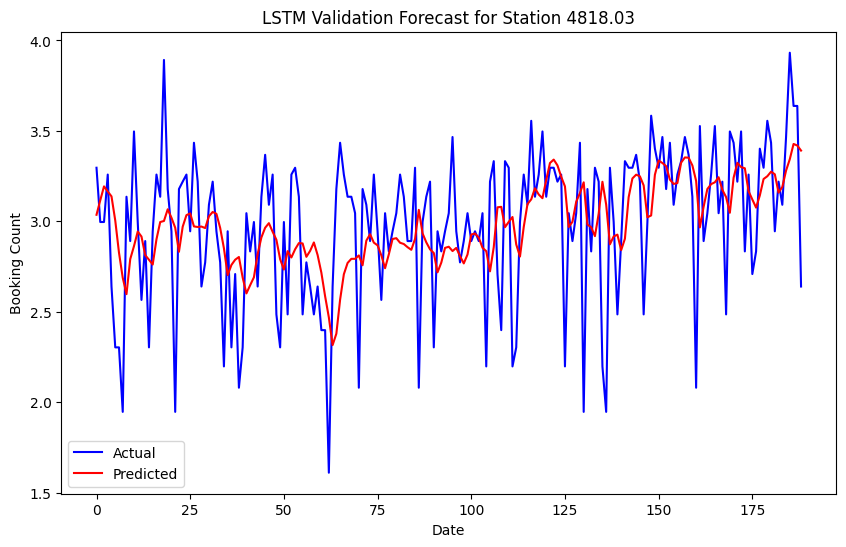

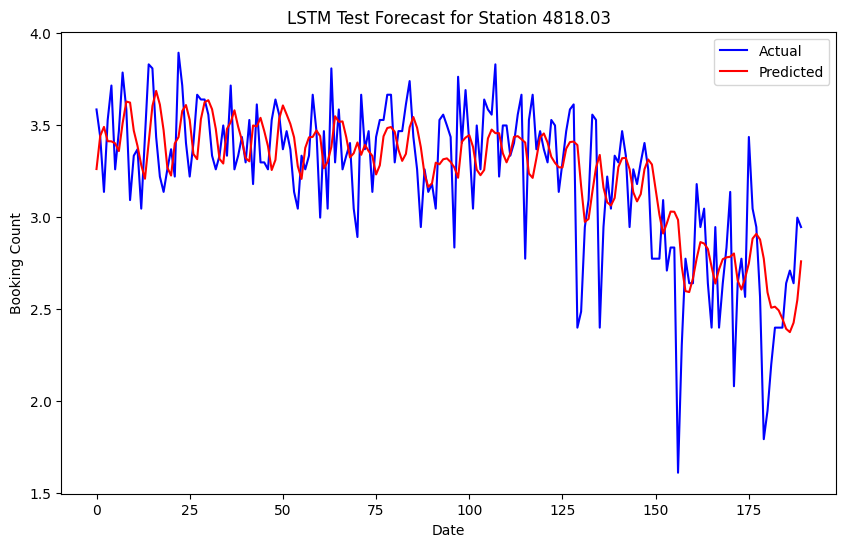

Validation Set Evaluation Metrics:
MSE: 0.1582909760283513
MAE: 0.3027861222583015
RMSE: 0.3978579847487685
MAPE: 11.236069457314613%

Test Set Evaluation Metrics:
MSE: 0.08764221923366829
MAE: 0.22407812239168842
RMSE: 0.29604428593314935
MAPE: 7.6259306287677004%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the datasets
file_paths = [
    "/content/2021Citibike daily trip counts&weather.csv",
    "/content/2022Citibike daily trip counts&weather.csv",
    "/content/2023Citibike daily trip counts&weather.csv",
    "/content/2024Citibike daily trip counts&weather.csv",
    "/content/Final_Urban_Feaatures_Merged_csv.csv"
]

# Load each CSV file
df_2021 = pd.read_csv(file_paths[0], dtype={'start_station_id': str})
df_2022 = pd.read_csv(file_paths[1], dtype={'start_station_id': str})
df_2023 = pd.read_csv(file_paths[2], dtype={'start_station_id': str})
df_2024 = pd.read_csv(file_paths[3], dtype={'start_station_id': str})
df_urban = pd.read_csv(file_paths[4])

# Combine the Citibike trip data for all years
df = pd.concat([
    df_2021[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2022[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2023[['start_station_id', 'DATE', 'booking_count', 'TAVG']],
    df_2024[['start_station_id', 'DATE', 'booking_count', 'TAVG']]
])

# Filter the data for station 4818.03 only
df_station = df[df['start_station_id'] == '4818.03']

# Convert 'DATE' to datetime format
df_station['DATE'] = pd.to_datetime(df_station['DATE'], errors='coerce')

# Use the 'TAVG' as the temperature column directly
df_station = df_station.dropna(subset=['booking_count', 'DATE'])

# Rename columns to match LSTM input format
df_station.rename(columns={'DATE': 'ds', 'booking_count': 'y', 'TAVG': 'temperature'}, inplace=True)

# Feature Engineering: Create 'day_of_week' and 'is_weekend' to capture weekly seasonality
df_station['day_of_week'] = df_station['ds'].dt.dayofweek
df_station['is_weekend'] = df_station['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Sort the data by 'ds' (date)
df_station = df_station.sort_values('ds')

# Apply log transformation (log(1+x)) to 'y' (booking count)
df_station['y'] = np.log1p(df_station['y'])

# Split data into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(df_station))
val_size = int(0.15 * len(df_station))

train = df_station[:train_size]
validation = df_station[train_size:train_size + val_size]
test = df_station[train_size + val_size:]

# Normalize the 'y' values (booking_count) and other features (temperature, is_weekend)
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_temp = MinMaxScaler(feature_range=(0, 1))
scaler_weekend = MinMaxScaler(feature_range=(0, 1))

train_scaled_y = scaler_y.fit_transform(train[['y']])
validation_scaled_y = scaler_y.transform(validation[['y']])
test_scaled_y = scaler_y.transform(test[['y']])

train_scaled_temp = scaler_temp.fit_transform(train[['temperature']])
validation_scaled_temp = scaler_temp.transform(validation[['temperature']])
test_scaled_temp = scaler_temp.transform(test[['temperature']])

train_scaled_weekend = scaler_weekend.fit_transform(train[['is_weekend']])
validation_scaled_weekend = scaler_weekend.transform(validation[['is_weekend']])
test_scaled_weekend = scaler_weekend.transform(test[['is_weekend']])

# Prepare the data for LSTM: Reshape the data into sequences (look-back window)
def create_sequences(data_y, data_temp, data_weekend, window_size):
    X, y = [], []
    for i in range(window_size, len(data_y)):
        X.append(np.column_stack((data_y[i-window_size:i], data_temp[i-window_size:i], data_weekend[i-window_size:i])))
        y.append(data_y[i])
    return np.array(X), np.array(y)

# Window size for LSTM (number of previous days to use for forecasting)
window_size = 30

X_train, y_train = create_sequences(train_scaled_y, train_scaled_temp, train_scaled_weekend, window_size)
X_val, y_val = create_sequences(validation_scaled_y, validation_scaled_temp, validation_scaled_weekend, window_size)
X_test, y_test = create_sequences(test_scaled_y, test_scaled_temp, test_scaled_weekend, window_size)

# Reshape the data for LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))  # 3 features: booking_count, temperature, is_weekend
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 3))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer with one value for prediction

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Plot the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# Invert scaling to get actual values
y_pred_val = scaler_y.inverse_transform(y_pred_val)
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot validation results
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(y_pred_val, label='Predicted', color='red')
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Plot test results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred_test, label='Predicted', color='red')
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.show()

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = sqrt(mse_val)
mape_val = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100

print(f"Validation Set Evaluation Metrics:")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = sqrt(mse_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\nTest Set Evaluation Metrics:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")


## Rounding is used because booking counts are discrete values, and having fractional values doesn't make sense in this context. While the model predicts continuous values, rounding makes the results more realistic by aligning them with actual booking counts, which are always integers. However, if the decimals have significance in your application, you can skip rounding.

Validation Set Actual vs Predicted (Rounded to Integers):
          Date  Actual  Predicted
0   2023-11-19    26.0         20
1   2023-11-20    19.0         22
2   2023-11-21    19.0         23
3   2023-11-22    25.0         23
4   2023-11-23    13.0         22
..         ...     ...        ...
184 2024-05-21    31.0         26
185 2024-05-22    50.0         27
186 2024-05-23    37.0         30
187 2024-05-24    37.0         30
188 2024-05-25    13.0         29

[189 rows x 3 columns]

Test Set Actual vs Predicted (Rounded to Integers):
          Date  Actual  Predicted
0   2024-06-25    35.0         25
1   2024-06-26    30.0         30
2   2024-06-27    22.0         32
3   2024-06-28    33.0         29
4   2024-06-29    40.0         29
..         ...     ...        ...
185 2024-12-27    13.0         10
186 2024-12-28    14.0         10
187 2024-12-29    13.0         10
188 2024-12-30    19.0         12
189 2024-12-31    18.0         15

[190 rows x 3 columns]


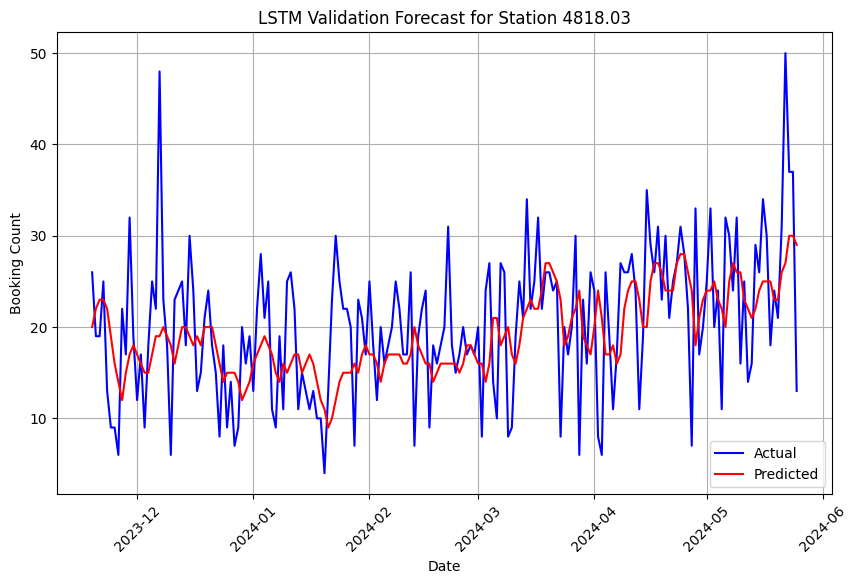

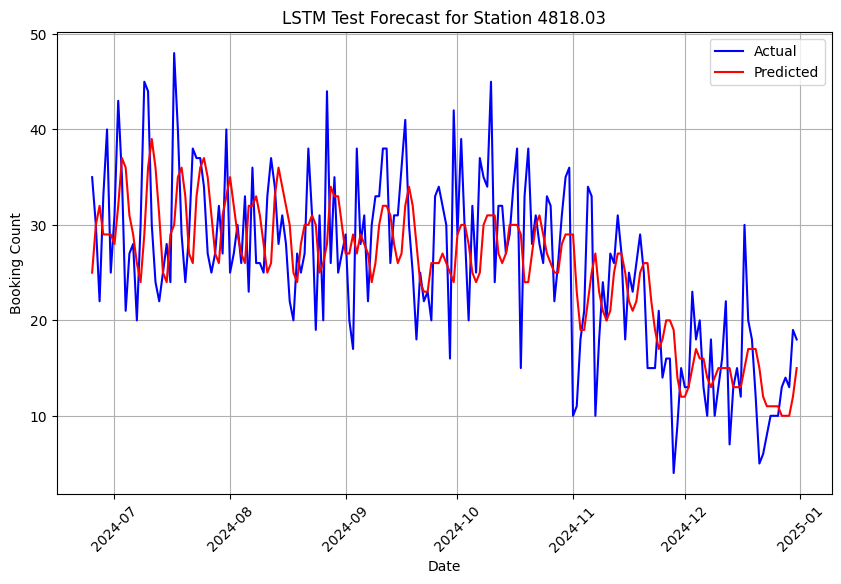

In [ ]:
# Ensure that both validation and test sets have the correct date column after slicing
validation_dates = validation['ds'].iloc[window_size:].reset_index(drop=True)
test_dates = test['ds'].iloc[window_size:].reset_index(drop=True)

# Ensure y_val_actual and y_pred_val_actual are 1D arrays
validation_comparison = pd.DataFrame({
    'Date': validation_dates,  # Reset the index for the dates
    'Actual': y_val_actual.flatten(),  # Flatten the array to 1D
    'Predicted': y_pred_val_actual.flatten()  # Flatten the array to 1D
})

# Print the validation comparison
print("Validation Set Actual vs Predicted (Rounded to Integers):")
print(validation_comparison)

test_comparison = pd.DataFrame({
    'Date': test_dates,  # Reset the index for the dates
    'Actual': y_test_actual.flatten(),  # Flatten the array to 1D
    'Predicted': y_pred_test_actual.flatten()  # Flatten the array to 1D
})

# Print the test comparison
print("\nTest Set Actual vs Predicted (Rounded to Integers):")
print(test_comparison)

# Now, for plotting with actual dates on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(validation_dates, y_val_actual, label='Actual', color='blue')  # Plot actual values
plt.plot(validation_dates, y_pred_val_actual, label='Predicted', color='red')  # Plot predicted values
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

# Plot test results
plt.figure(figsize=(10, 6))
plt.plot(test_dates, y_test_actual, label='Actual', color='blue')  # Plot actual values
plt.plot(test_dates, y_pred_test_actual, label='Predicted', color='red')  # Plot predicted values
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

# Calculate MSE, MAE, RMSE, MAPE for Validation
mse_val = mean_squared_error(validation_comparison['Actual'], validation_comparison['Predicted'])
mae_val = mean_absolute_error(validation_comparison['Actual'], validation_comparison['Predicted'])
rmse_val = sqrt(mse_val)
mape_val = np.mean(np.abs((validation_comparison['Actual'] - validation_comparison['Predicted']) / validation_comparison['Actual'])) * 100

print(f"Validation Set Evaluation Metrics:")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

# Calculate MSE, MAE, RMSE, MAPE for Test
mse_test = mean_squared_error(test_comparison['Actual'], test_comparison['Predicted'])
mae_test = mean_absolute_error(test_comparison['Actual'], test_comparison['Predicted'])
rmse_test = sqrt(mse_test)
mape_test = np.mean(np.abs((test_comparison['Actual'] - test_comparison['Predicted']) / test_comparison['Actual'])) * 100

print(f"\nTest Set Evaluation Metrics:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")


Validation Set Evaluation Metrics:
MSE: 54.899470899470906
MAE: 5.767195767195767
RMSE: 7.409417716627327
MAPE: 37.82525106709632%

Test Set Evaluation Metrics:
MSE: 48.02105263157895
MAE: 5.557894736842106
RMSE: 6.929722406531083
MAPE: 26.706890186067884%


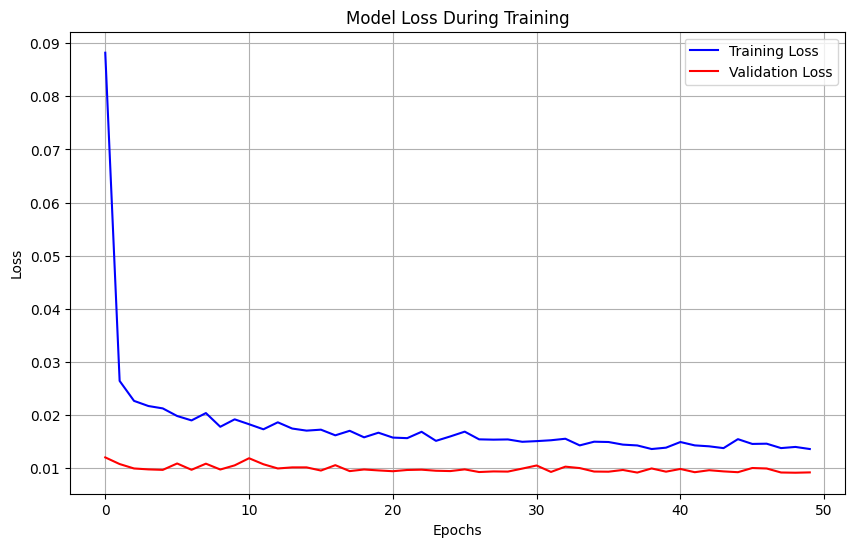

In [ ]:
# Plot the loss over epochs (Training and Validation Loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


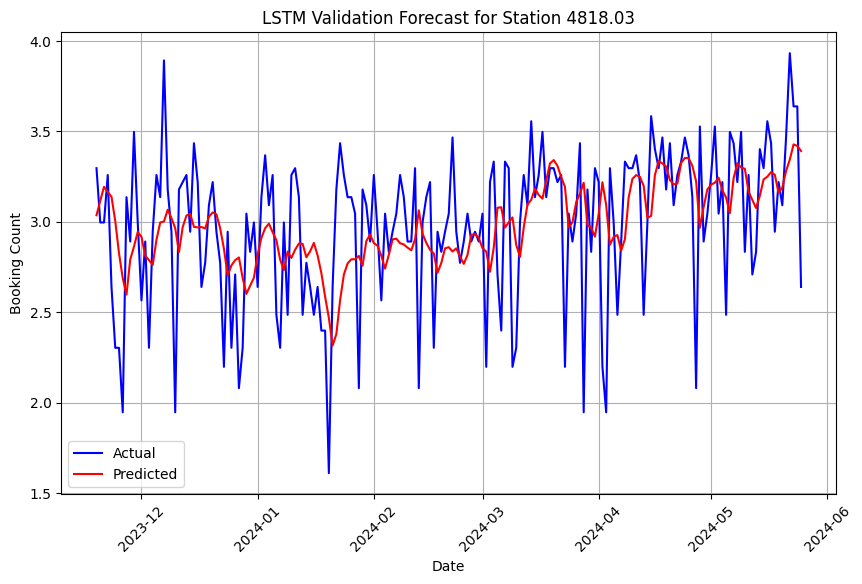

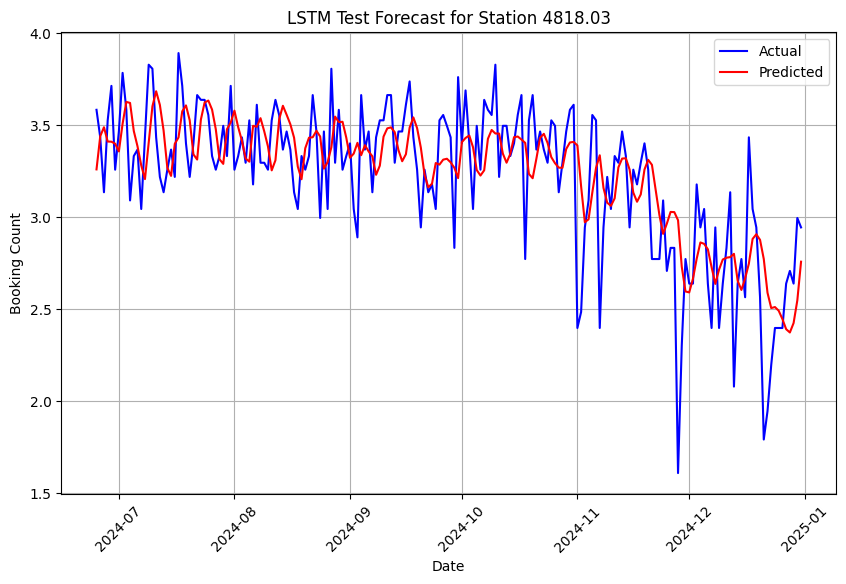

In [ ]:
# Plot the validation results with the date on x-axis
plt.figure(figsize=(10, 6))
# Adjust validation['ds'] to match the size of y_val
plt.plot(validation['ds'][window_size:], y_val, label='Actual', color='blue')
plt.plot(validation['ds'][window_size:], y_pred_val, label='Predicted', color='red')
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

# Plot the test results with the date on x-axis
plt.figure(figsize=(10, 6))
# Adjust test['ds'] to match the size of y_test
plt.plot(test['ds'][window_size:], y_test, label='Actual', color='blue')
plt.plot(test['ds'][window_size:], y_pred_test, label='Predicted', color='red')
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

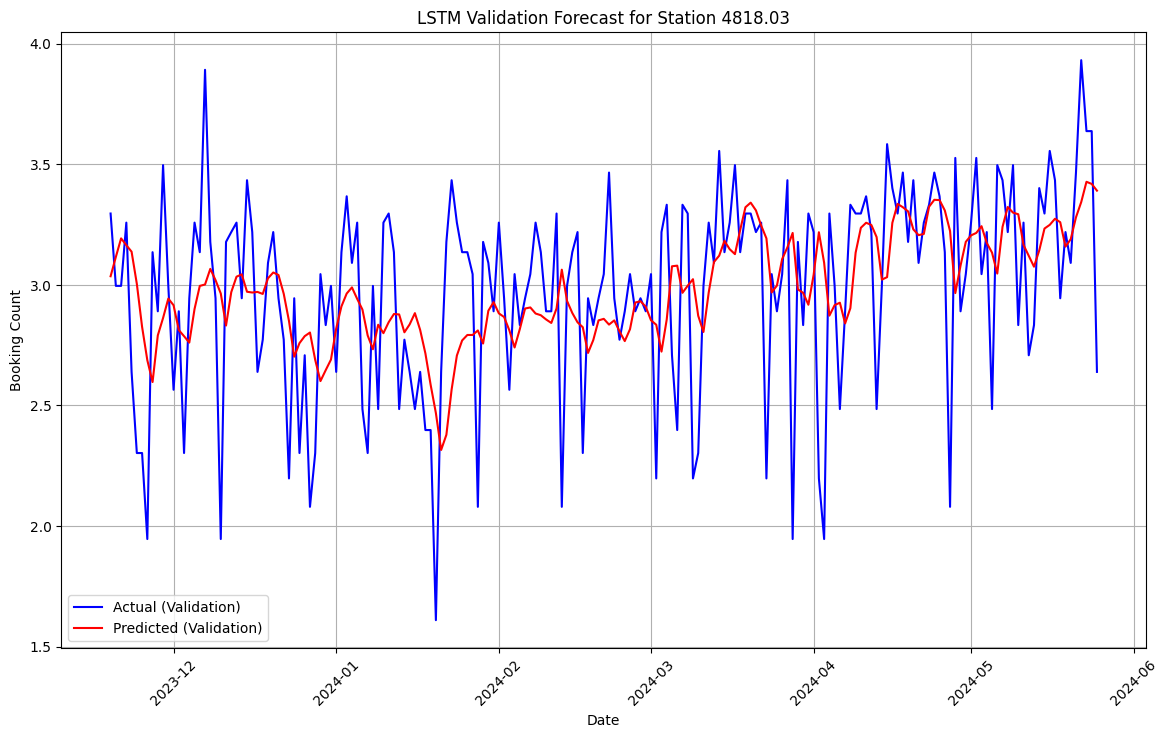

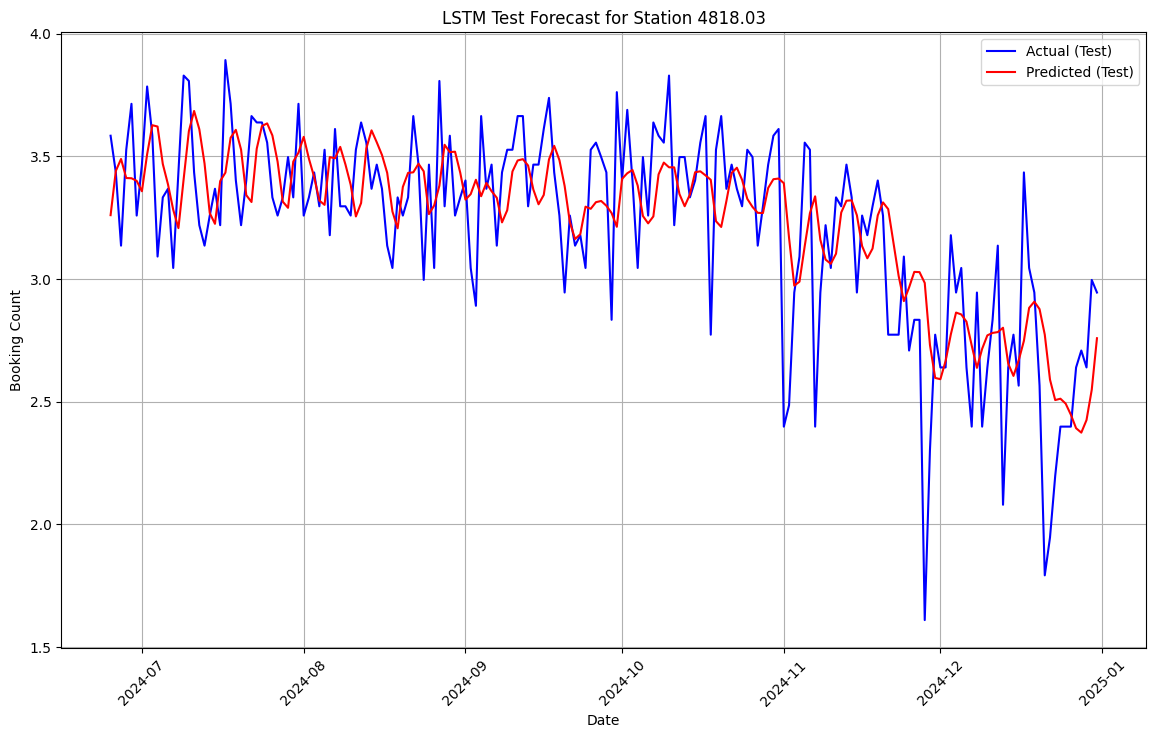

Validation Set Evaluation Metrics:
MSE: 0.1582909760283513
MAE: 0.3027861222583015
RMSE: 0.3978579847487685
MAPE: 11.236069457314613%

Test Set Evaluation Metrics:
MSE: 0.08764221923366829
MAE: 0.22407812239168842
RMSE: 0.29604428593314935
MAPE: 13.104763616104403%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


# Plot the validation results
plt.figure(figsize=(14, 8))
# Adjust validation['ds'] to match the size of y_pred_val
plt.plot(validation['ds'][window_size:], validation['y'][window_size:], label='Actual (Validation)', color='blue')
plt.plot(validation['ds'][window_size:], y_pred_val, label='Predicted (Validation)', color='red')
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot the test results
plt.figure(figsize=(14, 8))
# Adjust test['ds'] to match the size of y_pred_test
plt.plot(test['ds'][window_size:], test['y'][window_size:], label='Actual (Test)', color='blue')
plt.plot(test['ds'][window_size:], y_pred_test, label='Predicted (Test)', color='red')
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Evaluation metrics for the validation set
# Adjust validation['y'] to match the size of y_pred_val and convert to NumPy array
mse_val = mean_squared_error(validation['y'][window_size:].values, y_pred_val)
mae_val = mean_absolute_error(validation['y'][window_size:].values, y_pred_val)
rmse_val = sqrt(mse_val)
# Convert both to NumPy arrays for MAPE calculation
mape_val = np.mean(np.abs((validation['y'][window_size:].values - y_pred_val) / validation['y'][window_size:].values)) * 100

# Evaluation metrics for the test set
# Adjust test['y'] to match the size of y_pred_test and convert to NumPy array
mse_test = mean_squared_error(test['y'][window_size:].values, y_pred_test)
mae_test = mean_absolute_error(test['y'][window_size:].values, y_pred_test)
rmse_test = sqrt(mse_test)
# Convert both to NumPy arrays for MAPE calculation
mape_test = np.mean(np.abs((test['y'][window_size:].values - y_pred_test) / test['y'][window_size:].values)) * 100

# Print the evaluation metrics for validation and test sets
print("Validation Set Evaluation Metrics:")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

print("\nTest Set Evaluation Metrics:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")

In [ ]:
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def build_model(hp):
    model = Sequential()

    # Hyperparameter tuning for the number of LSTM units and layers
    model.add(layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50),
                          activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(layers.LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), activation='relu'))
    model.add(Dropout(0.2))

    model.add(layers.Dense(1))

    # Hyperparameter tuning for the learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Hyperparameter tuning with Keras Tuner
tuner = kt.Hyperband(build_model, objective='val_loss', max_epochs=10, factor=3, directory='my_dir', project_name='intro_to_kt')

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test set
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Best model test loss: {test_loss}")


Trial 30 Complete [00h 01m 06s]
val_loss: 5.249723434448242

Best val_loss So Far: 5.00864315032959
Total elapsed time: 00h 10m 27s
Best model test loss: 5.7897443771362305


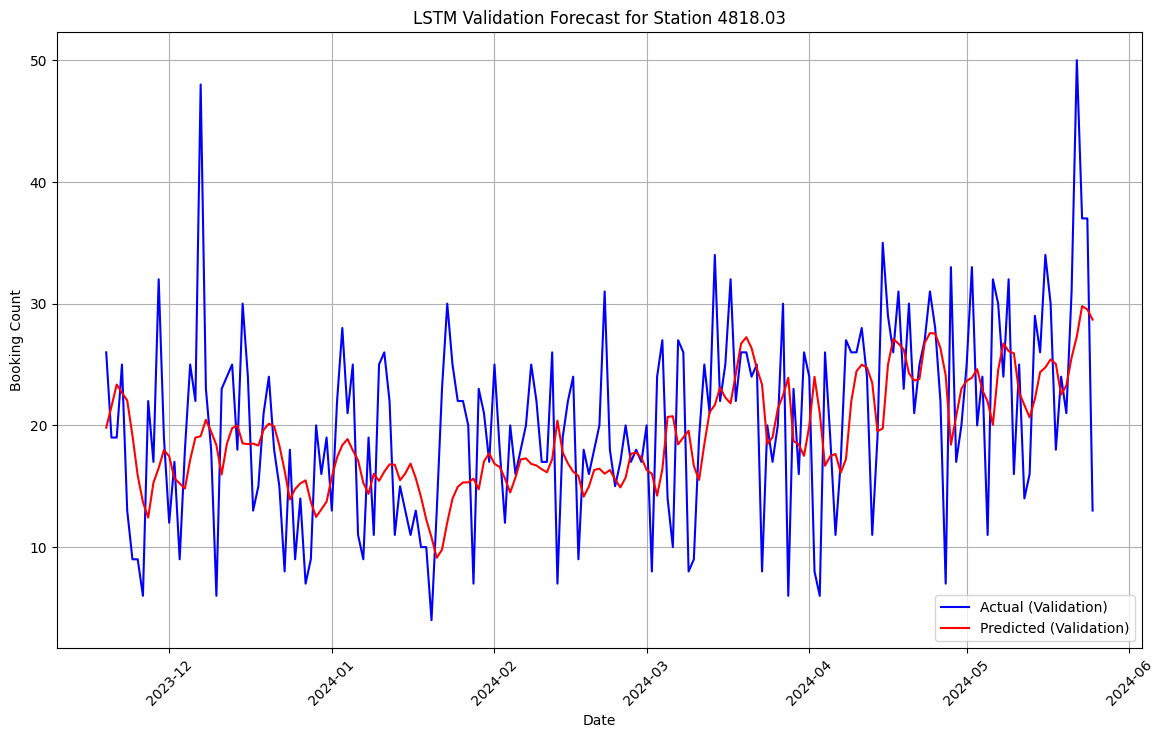

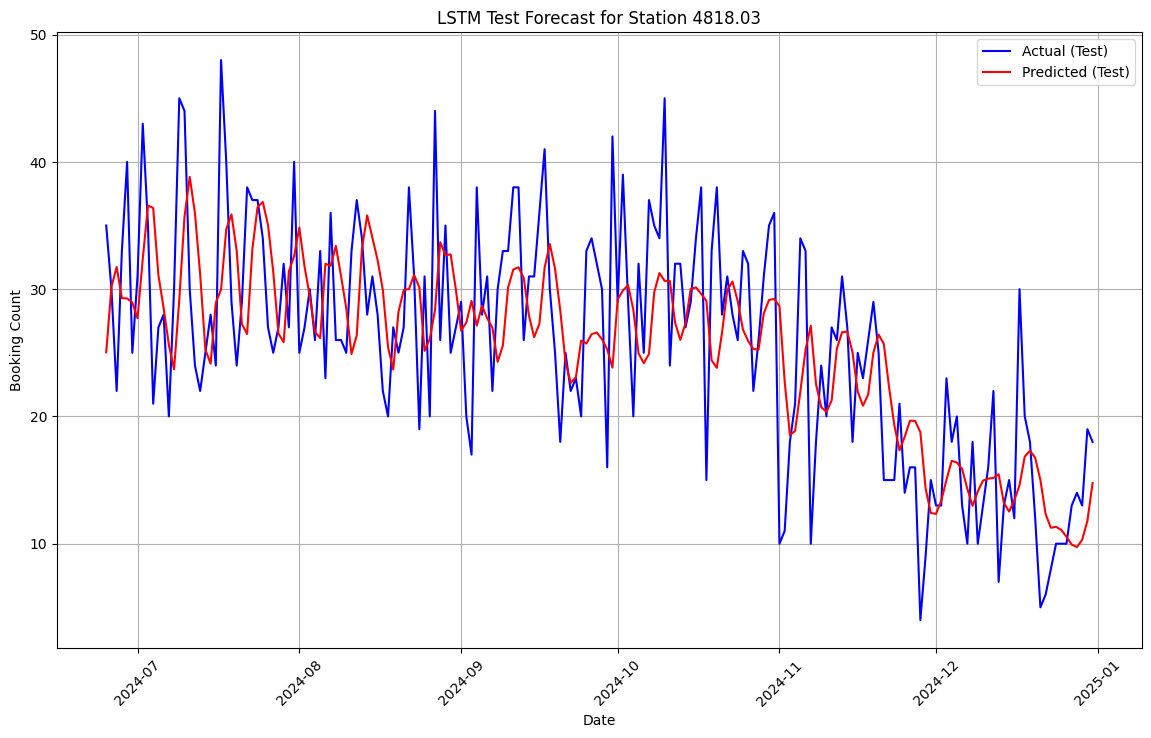

Validation Set Evaluation Metrics (Real Counts):
MSE: 54.51354119451063
MAE: 5.75060261115826
RMSE: 7.383328598573318
MAPE: 45.902889622543%

Test Set Evaluation Metrics (Real Counts):
MSE: 48.110165734531954
MAE: 5.57272149136192
RMSE: 6.936149200711585
MAPE: 26.829343531222484%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import numpy as np

# Inverse log transformation to get the actual booking counts
y_val_actual = np.expm1(y_val)  # Inverse of log1p for validation
y_pred_val_actual = np.expm1(y_pred_val)  # Inverse of log1p for predicted values (validation)

y_test_actual = np.expm1(y_test)  # Inverse of log1p for test
y_pred_test_actual = np.expm1(y_pred_test)  # Inverse of log1p for predicted values (test)

# Plot the validation results with real booking counts
plt.figure(figsize=(14, 8))
plt.plot(validation['ds'][window_size:], y_val_actual, label='Actual (Validation)', color='blue')
plt.plot(validation['ds'][window_size:], y_pred_val_actual, label='Predicted (Validation)', color='red')
plt.title("LSTM Validation Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot the test results with real booking counts
plt.figure(figsize=(14, 8))
plt.plot(test['ds'][window_size:], y_test_actual, label='Actual (Test)', color='blue')
plt.plot(test['ds'][window_size:], y_pred_test_actual, label='Predicted (Test)', color='red')
plt.title("LSTM Test Forecast for Station 4818.03")
plt.xlabel("Date")
plt.ylabel("Booking Count")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Evaluation metrics for the validation set (with real values)
mse_val = mean_squared_error(y_val_actual, y_pred_val_actual)
mae_val = mean_absolute_error(y_val_actual, y_pred_val_actual)
rmse_val = sqrt(mse_val)
mape_val = np.mean(np.abs((y_val_actual - y_pred_val_actual) / y_val_actual)) * 100

# Evaluation metrics for the test set (with real values)
mse_test = mean_squared_error(y_test_actual, y_pred_test_actual)
mae_test = mean_absolute_error(y_test_actual, y_pred_test_actual)
rmse_test = sqrt(mse_test)
mape_test = np.mean(np.abs((y_test_actual - y_pred_test_actual) / y_test_actual)) * 100

# Print the evaluation metrics for validation and test sets
print("Validation Set Evaluation Metrics (Real Counts):")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"RMSE: {rmse_val}")
print(f"MAPE: {mape_val}%")

print("\nTest Set Evaluation Metrics (Real Counts):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"MAPE: {mape_test}%")


# SARIMAX